In [1]:
import os, sys

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from sklearn.utils.extmath import row_norms
from sklearn.metrics.pairwise import _euclidean_distances


project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

import yace.helpers.evaluation as yace_eval

from yace.run_worker import JobInfo


In [2]:
def get_raw_results(file_paths):
    data_frames = []
    for index, job_info_path in enumerate(file_paths):
        job_info = JobInfo.load_json(job_info_path)
        experiment_type = job_info.command_params["experiment-type"]
        working_dir = job_info_path.parent
        duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
        
        distortions_paths = list(working_dir.glob("distortions*.feather"))
        if len(distortions_paths) == 0:
            continue

        df_perf_data = pd.concat([
            pd.read_feather(file_path)
            for file_path in distortions_paths
        ])
        df_perf_data["experiment_id"] = working_dir.name
        df_perf_data["experiment_name"] = working_dir.parent.name
        df_perf_data["experiment_type"] = experiment_type
        df_perf_data["running_time_secs"] = duration_secs
        
        df_perf_data["algorithm"] = job_info.experiment_params["algorithm_name"]
        df_perf_data["job_info_path"] = job_info_path
        
        for param, val in job_info.experiment_params.items():
            df_perf_data[f"{param}"] = val
        
        data_frames.append(df_perf_data)
    df_data = pd.concat(data_frames)
    return df_data

def add_combined_mean_std(df: pd.DataFrame, attr: str):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        return f"{mean:0.4f} ({std:0.5f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)


In [3]:
job_info_paths = list(Path("../data/experiments-odin/adv/full_unadjusted_01/").glob("**/job-info.json"))
print(f"Number of job files: {len(job_info_paths)}")

Number of job files: 60


In [4]:
df_raw_results = get_raw_results(job_info_paths)
print(f"Number of results: {df_raw_results.shape[0]}")

Number of results: 11900


In [5]:
grouping_cols = ["experiment_name", "epsilon", "k",  "algorithm_name", "solution_type"]
aggregation_spec = dict(
    n_solutions=("distortion", "count"),
    distortion_mean=("distortion", np.mean),
    distortion_std=("distortion", np.std),
    input_cost_mean=("input_cost", np.mean),
    input_cost_std= ("input_cost", np.std),
    coreset_cost_mean=("coreset_cost", np.mean),
    coreset_cost_std= ("coreset_cost", np.std),
)
df_grouped = df_raw_results.groupby(grouping_cols).agg(**aggregation_spec).reset_index()
df_grouped

,experiment_name,epsilon,k,algorithm_name,solution_type,n_solutions,distortion_mean,distortion_std,input_cost_mean,input_cost_std,coreset_cost_mean,coreset_cost_std
0,full_unadjusted_01,0.01,10,sensitivity-sampling,adv0_33,50,1.017628,0.007688,1.920406e+07,2.331217e+06,1.887242e+07,2.293770e+06
1,full_unadjusted_01,0.01,10,sensitivity-sampling,adv0_50,50,1.017390,0.007981,1.669361e+07,3.129504e+06,1.640845e+07,3.074279e+06
2,full_unadjusted_01,0.01,10,sensitivity-sampling,adv0_50_fixed,50,1.016642,0.010868,1.624405e+07,3.305812e+06,1.597030e+07,3.199625e+06
3,full_unadjusted_01,0.01,10,sensitivity-sampling,adv0_67,50,1.017377,0.012506,1.298247e+07,3.942579e+06,1.276684e+07,3.863593e+06
4,full_unadjusted_01,0.01,10,sensitivity-sampling-ex,adv0_33,50,1.020574,0.011723,1.849933e+07,1.928621e+06,1.817176e+07,1.878521e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
233,full_unadjusted_01,0.20,100,sensitivity-sampling-ex,adv0_67,50,1.048128,0.004529,2.662236e+05,4.335602e+02,2.540038e+05,1.192518e+03
234,full_unadjusted_01,0.20,100,uniform-sampling,adv0_33,50,1.002741,0.001851,2.660956e+05,3.375611e+02,2.666891e+05,7.155197e+02
235,full_unadjusted_01,0.20,100,uniform-sampling,adv0_50,50,1.003021,0.002158,2.661810e+05,3.602020e+02,2.667473e+05,9.237819e+02
236,full_unadjusted_01,0.20,100,uniform-sampling,adv0_50_fixed,50,1.002829,0.002177,2.660292e+05,3.804593e+02,2.666098e+05,7.229061e+02


In [6]:
pd.pivot(
    data=df_grouped,
    index=["experiment_name", "epsilon", "k", "solution_type"],
    columns=["algorithm_name"], 
    values="distortion_mean"
)

algorithm_name                                sensitivity-sampling  \
experiment_name    epsilon k   solution_type                         
full_unadjusted_01 0.01    10  adv0_33                    1.017628   
                               adv0_50                    1.017390   
                               adv0_50_fixed              1.016642   
                               adv0_67                    1.017377   
                           20  adv0_33                    1.002100   
...                                                            ...   
                   0.20    70  adv0_67                    1.024976   
                           100 adv0_33                    1.011039   
                               adv0_50                    1.010695   
                               adv0_50_fixed              1.010884   
                               adv0_67                    1.010713   

algorithm_name                                sensitivity-sampling-ex  \
experiment_name    epsilon k   solution_type                            
full_unadjusted_01 0.01    10  adv0_33                       1.020574   
                               adv0_50                       1.017339   
                               adv0_50_fixed                 1.025735   
                               adv0_67                       1.026954   
                           20  adv0_33                       1.004222   
...                                                               ...   
                   0.20    70  adv0_67                       1.017263   
                           100 adv0_33                       1.048682   
                               adv0_50                       1.048082   
                               adv0_50_fixed                 1.047549   
                               adv0_67                       1.048128   

algorithm_name                                uniform-sampling  
experiment_name    epsilon k   solution_type                    
full_unadjusted_01 0.01    10  adv0_33                1.009081  
                               adv0_50                1.011189  
                               adv0_50_fixed          1.008369  
                               adv0_67                1.012429  
                           20  adv0_33                1.002167  
...                                                        ...  
                   0.20    70  adv0_67                1.029480  
                           100 adv0_33                1.002741  
                               adv0_50                1.003021  
                               adv0_50_fixed          1.002829  
                               adv0_67                1.003713  

[80 rows x 3 columns]

In [7]:
colors = sns.color_palette("tab10")
colors = sns.color_palette("bright")
algorithms = np.sort(df_raw_results.algorithm_name.unique())[::-1]
algorithm_colors = {algo: colors[i] for i, algo in enumerate(algorithms)}
df_raw_results["k_formatted"] = "$k$=" + df_raw_results["k"].astype(str)
df_grouped["k_formatted"] = "$k$=" + df_grouped["k"].astype(str)

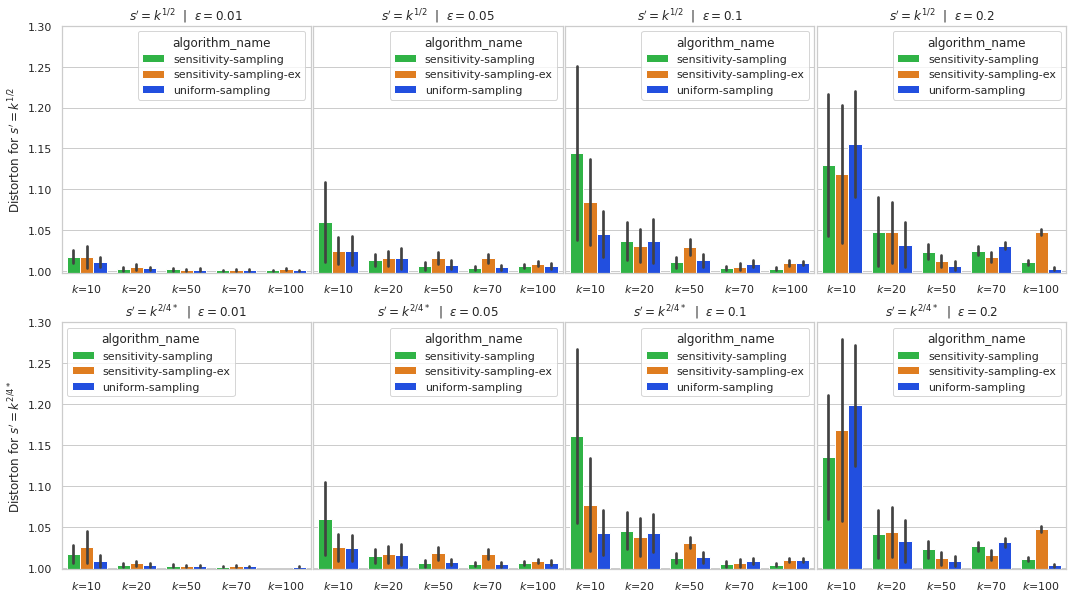

In [8]:
solution_types = np.sort(df_raw_results["solution_type"].unique())
solution_types = ["adv0_50", "adv0_50_fixed"]
epsilons = np.sort(df_raw_results["epsilon"].unique())
n_rows = len(solution_types)
n_cols = len(epsilons)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True, figsize=(18, 10))

for i, solution_type in enumerate(solution_types):
    for j, epsilon in enumerate(epsilons):
        ax = axes[i,j] # axes[i,j]
        f1 = df_raw_results["solution_type"] == solution_type
        f2 = df_raw_results["epsilon"] == epsilon
        df_filtered = df_raw_results[f1&f2].copy()
        df_filtered.sort_values(by=["k", "algorithm_name"], inplace=True)
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion", hue="algorithm_name", ci="sd", ax=ax, palette=algorithm_colors)
        ax.set_ylim(bottom=0.998, top=1.3)
        ratio = {"adv0_50_fixed": "2/4*", "adv0_50": "1/2", "adv0_33": "1/3", "adv0_67": "2/3"}[solution_type]
        s_prime = f"$s'=k^{{{ratio}}}$"
        ax.set_title(f"{s_prime}  |  $\\epsilon={epsilon}$")
        ax.set_ylabel(f"Distorton for {s_prime}")
        ax.set_xlabel("")
        if j > 0:
            ax.set_ylabel("")            
        if i == 0:
            ax.set_xlabel("")
fig.subplots_adjust(wspace=0.01)
fig.savefig(f"plots-barplot-distortions-instance-2-{df_raw_results.experiment_name.unique()[0]}.pdf", )

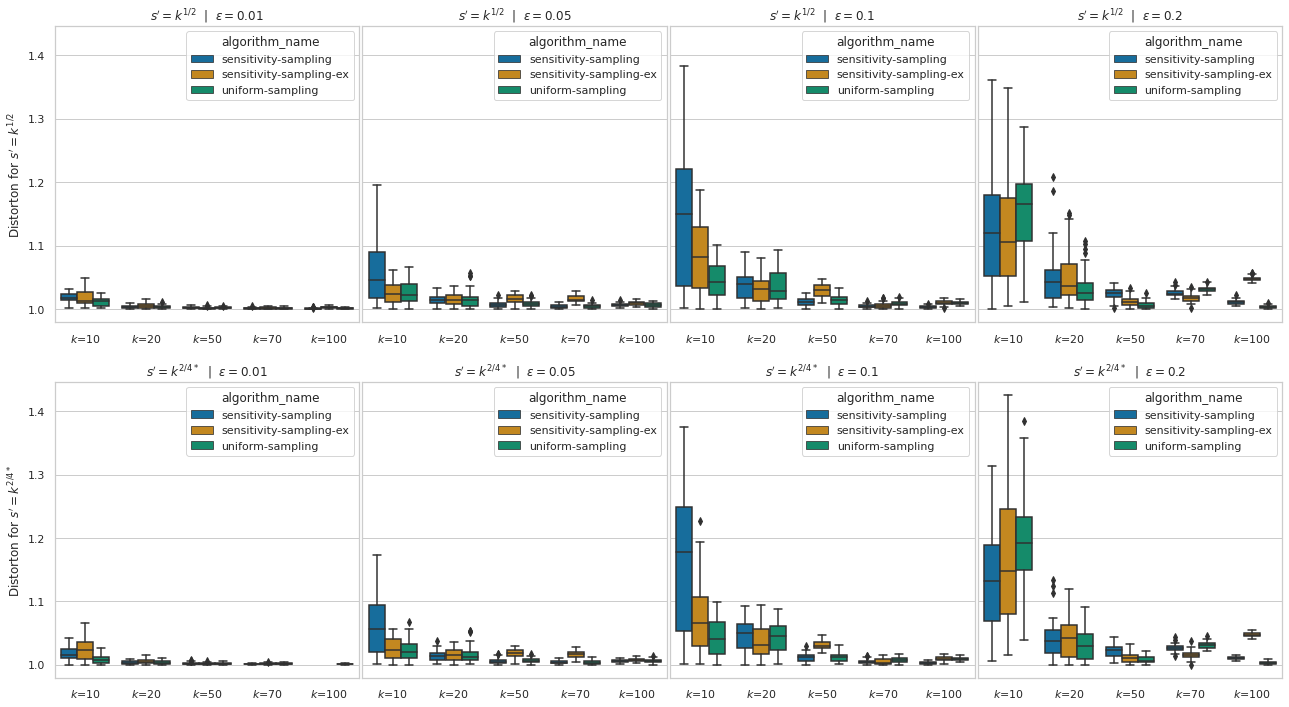

In [9]:
solution_types = np.sort(df_raw_results["solution_type"].unique())
solution_types = ["adv0_50", "adv0_50_fixed"]
epsilons = np.sort(df_raw_results["epsilon"].unique())
n_rows = len(solution_types)
n_cols = len(epsilons)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True, figsize=(22, 12))

for i, solution_type in enumerate(solution_types):
    for j, epsilon in enumerate(epsilons):
        ax = axes[i,j] # axes[i,j]
        f1 = df_raw_results["solution_type"] == solution_type
        f2 = df_raw_results["epsilon"] == epsilon
        df_filtered = df_raw_results[f1&f2].copy()
        df_filtered.sort_values(by=["k", "algorithm_name"], inplace=True)
        sns.boxplot(data=df_filtered, x="k_formatted", y="distortion", hue="algorithm_name", ax=ax, palette="colorblind")
        ratio = {"adv0_50_fixed": "2/4*", "adv0_50": "1/2", "adv0_33": "1/3", "adv0_67": "2/3"}[solution_type]
        s_prime = f"$s'=k^{{{ratio}}}$"
        ax.set_title(f"{s_prime}  |  $\\epsilon={epsilon}$")
        ax.set_ylabel(f"Distorton for {s_prime}")
        ax.set_xlabel("")
        if j > 0:
            ax.set_ylabel("")            
        if i == 0:
            ax.set_xlabel("")
fig.subplots_adjust(wspace=0.01)
fig.savefig(f"plots-boxplot-distortions-instance-2-{df_raw_results.experiment_name.unique()[0]}.pdf", )

## Costs

In [10]:
pd.pivot(
    data=df_grouped[(df_grouped.solution_type == "adv0_50_fixed") & (df_grouped.epsilon == 0.2)],
    index=["experiment_name", "epsilon", "k", "solution_type"],
    columns=["algorithm_name"], 
    values="input_cost_mean"
)

algorithm_name                                sensitivity-sampling  \
experiment_name    epsilon k   solution_type                         
full_unadjusted_01 0.2     10  adv0_50_fixed           3303.063027   
                           20  adv0_50_fixed          12756.304655   
                           50  adv0_50_fixed          72071.881106   
                           70  adv0_50_fixed         136352.975349   
                           100 adv0_50_fixed         266029.220500   

algorithm_name                                sensitivity-sampling-ex  \
experiment_name    epsilon k   solution_type                            
full_unadjusted_01 0.2     10  adv0_50_fixed              3303.063027   
                           20  adv0_50_fixed             12756.304655   
                           50  adv0_50_fixed             72071.881106   
                           70  adv0_50_fixed            136352.975349   
                           100 adv0_50_fixed            266029.220500   

algorithm_name                                uniform-sampling  
experiment_name    epsilon k   solution_type                    
full_unadjusted_01 0.2     10  adv0_50_fixed       3303.063027  
                           20  adv0_50_fixed      12756.304655  
                           50  adv0_50_fixed      72071.881106  
                           70  adv0_50_fixed     136352.975349  
                           100 adv0_50_fixed     266029.220500

In [11]:
pd.pivot(
    data=df_grouped[(df_grouped.solution_type == "adv0_50_fixed") & (df_grouped.epsilon == 0.2)],
    index=["experiment_name", "epsilon", "k", "solution_type"],
    columns=["algorithm_name"], 
    values="coreset_cost_mean"
)

algorithm_name                                sensitivity-sampling  \
experiment_name    epsilon k   solution_type                         
full_unadjusted_01 0.2     10  adv0_50_fixed           2923.392850   
                           20  adv0_50_fixed          12268.006296   
                           50  adv0_50_fixed          73665.801827   
                           70  adv0_50_fixed         132890.261860   
                           100 adv0_50_fixed         263166.333372   

algorithm_name                                sensitivity-sampling-ex  \
experiment_name    epsilon k   solution_type                            
full_unadjusted_01 0.2     10  adv0_50_fixed              3495.425456   
                           20  adv0_50_fixed             12249.955640   
                           50  adv0_50_fixed             71323.192459   
                           70  adv0_50_fixed            134231.327404   
                           100 adv0_50_fixed            253957.064542   

algorithm_name                                uniform-sampling  
experiment_name    epsilon k   solution_type                    
full_unadjusted_01 0.2     10  adv0_50_fixed       2767.576541  
                           20  adv0_50_fixed      12632.967052  
                           50  adv0_50_fixed      72271.525695  
                           70  adv0_50_fixed     132286.639447  
                           100 adv0_50_fixed     266609.828188

## Weight distribution

In [12]:
def select_experiment_per_algorithm(df_data, epsilon: float=0.2, k: int=10):
    results = []
    algorithms = df_data.algorithm.unique()
    for algo in algorithms:
        f1 = df_data["solution_type"] == "adv0_50"
        f2 = df_data["epsilon"] == epsilon
        f3 = df_data["algorithm"] == algo
        f4 = df_data["k"] == k
        
        df_filtered = df_data[f1&f2&f3&f4].copy()
        results.append(df_filtered.sample(1).copy())
    return pd.concat(results)

def get_weights(df_data, epsilon: float=0.2, k: int=10):
    results = dict()
    algorithms = df_data.algorithm.unique()
    for algo in algorithms:
        f1 = df_data["solution_type"] == "adv0_50"
        f2 = df_data["epsilon"] == epsilon
        f3 = df_data["algorithm"] == algo
        f4 = df_data["k"] == k
        
        df_filtered = df_data[f1&f2&f3&f4].copy()
        
        job_info_path = df_filtered.sample(1)["job_info_path"].iloc[0]
        weights = np.load(job_info_path.parent / "coreset-weights.npz")["matrix"]
        results[algo] = weights
    return results

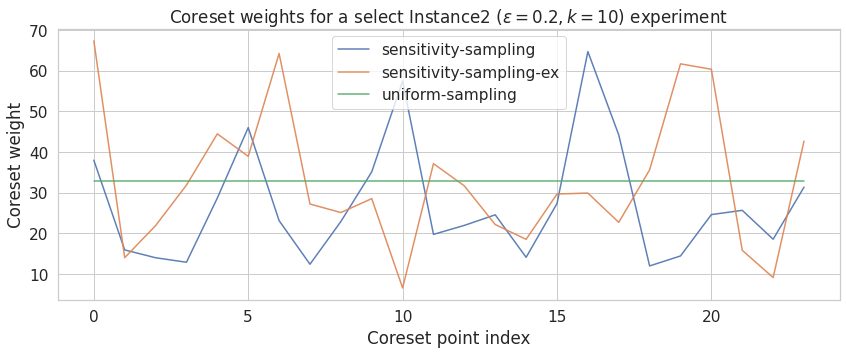

In [13]:
epsilon=0.2
k=10
weights_map = get_weights(df_data=df_raw_results, epsilon=epsilon, k=k)

n_weights = list(weights_map.values())[0].shape[0]
a = np.arange(n_weights)

algos = ["sensitivity-sampling", "sensitivity-sampling-ex", "uniform-sampling"]
# algos = ["sensitivity-sampling-ex", "uniform-sampling"]

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(14, 5))
    for algo in algos:
        coreset_weights = weights_map[algo]
        sns.lineplot(x=a, y=coreset_weights, label=algo, alpha=0.9, ax=ax)
    # for algo, coreset_weights in weights_map.items():
        # sns.lineplot(x=a, y=coreset_weights, label=algo, alpha=0.4, ax=ax)
    ax.set_ylabel("Coreset weight")
    ax.set_xlabel("Coreset point index")
    # ax.set_yscale("log")
    ax.set_title(f"Coreset weights for a select Instance2 ($\\epsilon={epsilon}, k={k}$) experiment ")

## Alpha = 0.2 k=10, fixed solution

In [14]:
epsilon=0.01
k=20
f1 = df_raw_results["solution_type"] == "adv0_50_fixed"
f2 = df_raw_results["epsilon"] == epsilon
f3 = df_raw_results["k"] == k
df_filtered = df_raw_results[f1&f2&f3].copy()

In [15]:
aggregation_spec = dict(
    n_solutions=("distortion", "count"),
    distortion_mean=("distortion", np.mean),
    distortion_median=("distortion", np.median),
    distortion_std=("distortion", np.std),
    input_cost_mean=("input_cost", np.mean),
    input_cost_median=("input_cost", np.median),
    input_cost_std=("input_cost", np.std),
    coreset_cost_mean=("coreset_cost", np.mean),
    coreset_cost_std= ("coreset_cost", np.std),
    
)
df_filtered.groupby("algorithm_name").agg(**aggregation_spec).T

algorithm_name,sensitivity-sampling,sensitivity-sampling-ex,uniform-sampling
n_solutions,5.000000e+01,5.000000e+01,5.000000e+01
distortion_mean,1.003639e+00,1.005105e+00,1.003806e+00
distortion_median,1.003579e+00,1.004284e+00,1.003364e+00
distortion_std,2.261577e-03,3.624594e-03,2.508243e-03
input_cost_mean,5.600947e+07,5.600947e+07,5.600947e+07
input_cost_median,5.366123e+07,5.366123e+07,5.366123e+07
input_cost_std,3.839070e+06,3.839070e+06,3.839070e+06
coreset_cost_mean,5.606797e+07,5.616740e+07,5.594026e+07
coreset_cost_std,3.808015e+06,3.876992e+06,3.799383e+06


<AxesSubplot:xlabel='algorithm_name', ylabel='cost'>

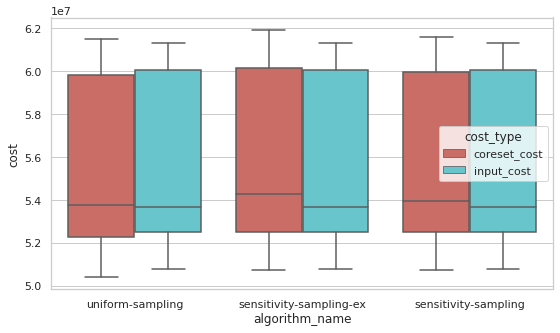

In [16]:
id_vars = df_filtered.columns[~df_filtered.columns.isin(["input_cost", "coreset_cost"])]
df_plot_data = pd.melt(df_filtered, id_vars=id_vars, var_name="cost_type", value_name="cost")

fig, ax = plt.subplots(figsize=(9, 5))
sns.boxplot(x="algorithm_name", y="cost", hue="cost_type", data=df_plot_data, ax=ax, palette="hls")

<AxesSubplot:xlabel='algorithm_name', ylabel='distortion'>

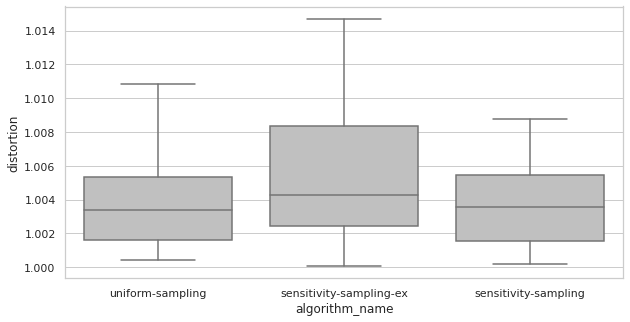

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x="algorithm_name", y="distortion", data=df_filtered, ax=ax, color="silver")